# Training CNN 64_128 model on all users except one then testing on that user. 
* This is done for each user in turn to help determine the accuracy and robustness of the model.
* This is also evaluated for 3s, 2s, 1.5s and 1s spectrogram windows to compare the trade-off between accuracy and lower latency.

### Summary
*   1, 1.5, 2 and 3 second windows tested
*   0 degree aspect angle
*   All movements
*   Cnn 64_128 model
*   Datsets:
    * 1: Miss out A
    * 2: Miss out B
    * 3: Miss out C
    * 4: Miss out D
    * 5: Miss out E
    * 6: Miss out F

## Train or Load Toggle
These variables set whether to load results or train the model.
* If set to True then the model will be trained, history saved, new graphs generated and saved and new analysis produced.
* If set to False then a pre-trained version of the model will be loaded along with a history object.

In [0]:
TRAIN_MODEL_3s = True
TRAIN_MODEL_2s = True
TRAIN_MODEL_1_5s = True
TRAIN_MODEL_1s = True

## Notebook setup

Allow editing of modules using editor (auto reloading)

In [0]:
# Needed to allow editing using PyCharm etc
%load_ext autoreload
%autoreload 2

The following cell is needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [4]:
import os
path = os.getcwd()
if path == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
elif path == 'D:\\Google Drive\\Level-4-Project\\notebooks\\baseline_model':
    BASE_PATH = "D:/Google Drive/Level-4-Project/"
    
elif path == "/export/home/2192793m":
    BASE_PATH = "/export/home/2192793m/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/processed/'
DATA_SETS = ["dataset_1/", "dataset_2/", "dataset_3/", "dataset_4/", "dataset_5/", "dataset_6/"]
DATA_SETS = ["dataset_1/", "dataset_2/"]

MODELS_PATH = BASE_PATH + 'models/baseline_model/leave_one_user_out_cnn_64_128/'
RESULTS_PATH = BASE_PATH + 'results/baseline_model/leave_one_user_out_cnn_64_128/'
REPORT_PATH = BASE_PATH + 'reports/baseline_model/leave_one_user_out_cnn_64_128/'
    
from src.models.original_models import cnn_64_128
from src.data import load_data
from src.visualization import multiple_plots, visualize

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Obtaining file:///content/gdrive/My%20Drive/Level-4-Project
  Found existing installation: src 0.1.0
    Can't uninstall 'src'. No files were found to uninstall.
  Running setup.py develop for src


Using TensorFlow backend.


Import remaining packages

In [0]:
import numpy as np
import sys
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
import sys
from sklearn.metrics import classification_report, confusion_matrix
import csv
from keras.models import load_model
import pickle

In [0]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

## Experiment Setup and Parameter Definition

In [0]:
target_names = ["walking", "pushing", "sitting", "pulling", "circling", "clapping", "bending"]
nb_classes = len(target_names)
batch_size = 100
nb_epoch = 20
nb_epoch = 1
# input image dimensions
img_rows, img_cols = 75, 75

load_datasets takes in the window size (1, 1.5, 2 or 3) as a string combines with an array datasets of the form ["dataset_1/", "dataset_2/",...].

Returned is a dictionary indexed by dataset name which contains the training and testing sets.

In [0]:
def load_datasets(window_size, datasets):
    datasets = {}
    # Loop through each dataset 1,2,3,4,5,6
    for dataset in DATA_SETS:
        # load the training and testing sets
        loaded_data = load_data.load_dataset(DATA_PATH + window_size + "/" + dataset)
        # convert class vectors to binary class matrices
        y_train = np_utils.to_categorical(loaded_data["train_labels"], nb_classes)
        y_test = np_utils.to_categorical(loaded_data["test_labels"], nb_classes)
        x_train = loaded_data["train_data"].astype('float32')
        x_test = loaded_data["test_data"].astype('float32')
        x_train /= 255
        x_test /= 255 
        # [:-1] removes backslash from string
        datasets[dataset[:-1]] = {
            "train_labels": y_train,
            "test_labels": y_test,
            "train_data": x_train,
            "test_data": x_test
        }
    return datasets

## Training and Evaluating Models

In [0]:
def train_model(train_data, train_labels, test_data, test_labels):
    model = cnn_64_128.make_model(img_rows, img_cols, nb_classes)
    # train the model using SGD + momentum.
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])

    history = model.fit(
        train_data,
        train_labels,
        batch_size=batch_size,
        epochs=nb_epoch,
        validation_data=(test_data, test_labels),
        shuffle=True, 
        verbose=1)
    y_pred = model.predict_classes(test_data)
    report = classification_report(np.argmax(data["test_labels"],axis=1), y_pred,target_names=target_names)
    conf_matrix = confusion_matrix(np.argmax(data["test_labels"],axis=1), y_pred)
    evaluation = model.evaluate(test_data, test_labels, batch_size=batch_size, verbose=0)
    return {
        "model": model,
        "history": history,
        "classification_report": report,
        "confusion_matrix": confusion_matrix,
        "evaluation": evaluation
    }

In [0]:
def save_results(results, window_length):
    for dataset_name, result in results.items():
        model = result.pop("model")
        model.save(MODELS_PATH + window_length + "/" + dataset_name + '.h5')
    with open(RESULTS_PATH + window_length + "_results.pkl", "wb") as file:
        pickle.dump(results, file)

In [0]:
def load_results(window_length):
    with open(RESULTS_PATH + window_length + "_results.pkl", "rb") as file:
        results = pickle.load(file)
    for dataset_name, result in results.items():
        result["model"] = load_model(MODELS_PATH + window_length + "/" + datset_name + '.h5')

### 3 second window

In [23]:
results_3_seconds = {}
if TRAIN_MODEL_3s:
    datasets = load_datasets("3", DATA_SETS)
    results_3_seconds = {}
    for dataset_name, data in datasets.items():
        result = train_model(data["train_data"], data["train_labels"], data["test_data"], data["test_labels"])
        results_3_seconds[dataset_name] = result
    save_results(results_3_seconds, "3")
    
else:
    try:
        results_3_seconds = load_results("3")
    except:
        print("No saved file exists")

Train on 36985 samples, validate on 7966 samples
Epoch 1/1
36985/36985 [==============================] - 76s 2ms/step - loss: 0.6033 - acc: 0.7750 - val_loss: 0.0400 - val_acc: 0.9913
Train on 36985 samples, validate on 7966 samples
Epoch 1/1
36985/36985 [==============================] - 76s 2ms/step - loss: 0.5353 - acc: 0.8063 - val_loss: 1.5111 - val_acc: 0.7165


### 2 second window

In [24]:
results_2_seconds = {}
if TRAIN_MODEL_2s:
    datasets = load_datasets("2", DATA_SETS)
    results_2_seconds = {}
    for dataset_name, data in datasets.items():
        result = train_model(data["train_data"], data["train_labels"], data["test_data"], data["test_labels"])
        results_2_seconds[dataset_name] = result
    save_results(results_2_seconds, "2")

else:
    try:
        results_2_seconds = load_results("2")
    except:
        print("No saved file exists")

Train on 37635 samples, validate on 8106 samples
Epoch 1/1
37635/37635 [==============================] - 78s 2ms/step - loss: 0.6810 - acc: 0.7480 - val_loss: 0.0668 - val_acc: 0.9822
Train on 37635 samples, validate on 8106 samples
Epoch 1/1
37635/37635 [==============================] - 78s 2ms/step - loss: 0.5949 - acc: 0.7814 - val_loss: 1.3319 - val_acc: 0.7123


### 1.5 second window

In [25]:
results_1_5_seconds = {}
if TRAIN_MODEL_1_5s:
    datasets = load_datasets("1_5", DATA_SETS)
    results_1_5_seconds = {}
    for dataset_name, data in datasets.items():
        result = train_model(data["train_data"], data["train_labels"], data["test_data"], data["test_labels"])
        results_1_5_seconds[dataset_name] = result
    save_results(results_1_5_seconds, "1_5")
else:
    try:
        results_1_5_seconds = load_results("1_5")
    except:
        print("No saved file exists")

Train on 37960 samples, validate on 8176 samples
Epoch 1/1
37960/37960 [==============================] - 80s 2ms/step - loss: 0.7835 - acc: 0.7031 - val_loss: 0.2166 - val_acc: 0.9161
Train on 37960 samples, validate on 8176 samples
Epoch 1/1
37960/37960 [==============================] - 79s 2ms/step - loss: 0.6298 - acc: 0.7719 - val_loss: 1.4215 - val_acc: 0.7180


### 1 second window

In [26]:
results_1_seconds = {}
if TRAIN_MODEL_1s:
    datasets = load_datasets("1", DATA_SETS)
    results_1_seconds = {}
    for dataset_name, data in datasets.items():
        result = train_model(data["train_data"], data["train_labels"], data["test_data"], data["test_labels"])
        results_1_seconds[dataset_name] = result
    save_results(results_1_seconds, "1")
else:
    try:
        results_1_seconds = load_results("1")
    except:
        print("No saved file exists")

Train on 38285 samples, validate on 8246 samples
Epoch 1/1
38285/38285 [==============================] - 80s 2ms/step - loss: 0.8922 - acc: 0.6637 - val_loss: 0.3239 - val_acc: 0.9065
Train on 38285 samples, validate on 8246 samples
Epoch 1/1
38285/38285 [==============================] - 79s 2ms/step - loss: 0.7825 - acc: 0.7100 - val_loss: 1.5884 - val_acc: 0.6927


## Analysis and Saving of Results

In [0]:
save_graphs = True

### Formatting of data

In [0]:
def convert_keys_to_description(results):
    # Renaming keys to make more meaninful (helps for reports and graphing)
    keys = list(results.keys())
    for key in keys:
        if key == "dataset_1":
            results["Test on A"] = results.pop(key)
        elif key == "dataset_2":
            results["Test on B"] = results.pop(key)
        elif key == "dataset_3":
            results["Test on C"] = results.pop(key)
        elif key == "dataset_4":
            results["Test on D"] = results.pop(key)
        elif key == "dataset_5":
            results["Test on E"] = results.pop(key)
        elif key == "dataset_6":
            results["Test on F"] = results.pop(key)
    return results

In [0]:
results_3_seconds = convert_keys_to_description(results_3_seconds)
results_2_seconds = convert_keys_to_description(results_2_seconds)
results_1_5_seconds = convert_keys_to_description(results_1_5_seconds)
results_1_seconds = convert_keys_to_description(results_1_seconds)

### Graphs

#### 3 Seconds, comparison of different datasets for test accuracy

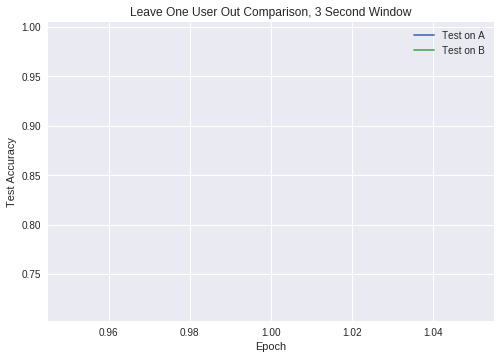

In [32]:
multiple_plots.plot_multiple_val_acc(
    results_3_seconds,
    "Leave One User Out Comparison, 3 Second Window",
    save=save_graphs,
    path=REPORT_PATH + "leave_one_user_out_comparison_3sec.svg")

#### 2 Seconds, comparison of different datasets for test accuracy

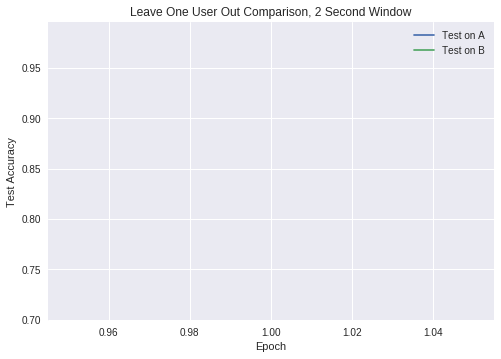

In [33]:
multiple_plots.plot_multiple_val_acc(
    results_2_seconds,
    "Leave One User Out Comparison, 2 Second Window",
    save=save_graphs,
    path=REPORT_PATH + "leave_one_user_out_comparison_2sec.svg")

#### 1.5 Seconds, comparison of different datasets for test accuracy

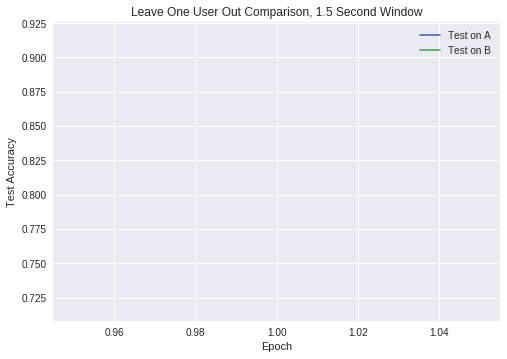

In [34]:
multiple_plots.plot_multiple_val_acc(
    results_1_5_seconds,
    "Leave One User Out Comparison, 1.5 Second Window",
    save=save_graphs,
    path=REPORT_PATH + "leave_one_user_out_comparison_1_5sec.svg")

#### 1 Seconds, comparison of different datasets for test accuracy

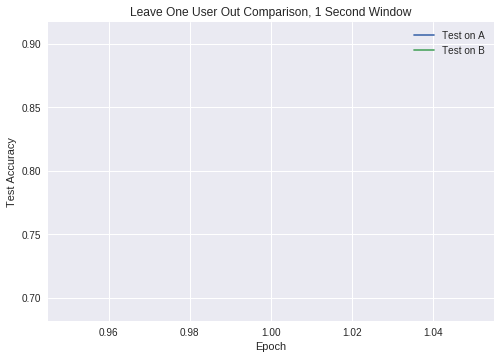

In [35]:
multiple_plots.plot_multiple_val_acc(
    results_1_seconds,
    "Leave One User Out Comparison, 1 Second Window",
    save=save_graphs,
    path=REPORT_PATH + "leave_one_user_out_comparison_1sec.svg")

#### Comparison of Time Window using Dataset 1, using test accuracy

In [0]:
def get_test_accuracy(results, dataset):
    return {"accuracy": results[dataset]["evaluation"][1]}

In [0]:
dataset = "Test on A"
window_results = {
    "3": get_test_accuracy(results_3_seconds, dataset),
    "2": get_test_accuracy(results_2_seconds, dataset),
    "1_5": get_test_accuracy(results_1_5_seconds, dataset),
    "1": get_test_accuracy(results_1_seconds, dataset)
}

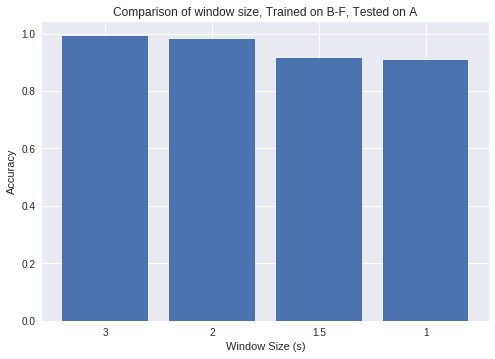

In [50]:
visualize.plot_evaluation_bar(
    window_results,
    ["3", "2", "1.5", "1"],
    "Comparison of window size, Trained on B-F, Tested on A",
    "Window Size (s)",
    "Accuracy",
    save=save_graphs,
    path=REPORT_PATH + "window_size_comparison.svg"
    )

### Save Classification Report and Confusion Matricies

In [0]:
# @ TODO